In [34]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
from statsmodels.sandbox.stats.multicomp import multipletests 
%matplotlib inline

В данном задании вам нужно будет

    - проанализировать АБ тест, проведенный на реальных пользователях Яндекса
    - подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
    - определить характер этих изменений и практическую значимость вводимого изменения
    - понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

    userID: уникальный идентификатор пользователя
    browser: браузер, который использовал userID
    slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
    n_clicks: количество кликов, которые пользоваль совершил за n_queries
    n_queries: количество запросов, который совершил userID, пользуясь браузером browser
    n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки. 

In [2]:
ab_test = pd.read_csv('ab_browser_test.csv')
ab_test.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [5]:
exp = ab_test[ab_test['slot'] == 'exp']
control = ab_test[ab_test['slot'] == 'control']

In [52]:
exp_clicks, control_clicks = exp['n_clicks'].sum(), control['n_clicks'].sum()

percent = (exp_clicks/control_clicks) * 100 - 100
print('Percent: %.3f' % percent)

Percent: 1.614


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha=.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

exp_mean = np.array(list(map(np.mean, get_bootstrap_samples(exp['n_clicks'].values, 100))))
control_mean = np.array(list(map(np.mean, get_bootstrap_samples(control['n_clicks'].values, 100))))

exp_median = np.array(list(map(np.median, get_bootstrap_samples(exp['n_clicks'].values, 100))))
control_median = np.array(list(map(np.median, get_bootstrap_samples(control['n_clicks'].values, 100))))

In [10]:
exp_mean[:5], control_mean[:5]

(array([11.58680304, 11.59703459, 11.57987073, 11.59318489, 11.63198025]),
 array([11.2113764 , 11.31036288, 11.33409476, 11.28608981, 11.3074109 ]))

In [11]:
exp_median[:5], control_median[:5]

(array([5., 5., 5., 5., 5.]), array([4., 4., 4., 4., 4.]))

In [12]:
mean_diff_conf_int = stat_intervals(control_mean - exp_mean)
print('means difference confidence interval: [%.4f, %.4f]' % tuple(mean_diff_conf_int))
median_diff_conf_int = stat_intervals(control_median - exp_median)
print('medians difference confidence interval: [%.4f, %.4f]' % tuple(median_diff_conf_int))

means difference confidence interval: [-0.3944, -0.2070]
medians difference confidence interval: [-1.0000, -1.0000]


Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

    - Получите из данных n_boot_samples псевдовыборок.
    - По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
    - Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
    - Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды 
    
В качестве ответа отметьте верные утвердения о значениях R^2, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.


In [13]:
np.random.seed(0)
n_boot_samples = 500
boot_samples = get_bootstrap_samples(control['n_clicks'].values, n_boot_samples)

control_boot_means = np.array(list(map(np.mean, boot_samples)))

In [14]:
control_boot_means[:10]

array([11.23802863, 11.25842898, 11.32580811, 11.33194402, 11.25147775,
       11.26541184, 11.25684404, 11.35563021, 11.21341468, 11.30774827])

In [15]:
control_boot_chi_squared = np.array([np.power(boot_samples[i] - control_boot_means[i], 2).sum() 
                                     for i in range(len(boot_samples))])

q-q plot for control_boot_means

R-squared for control_boot_means: 0.998


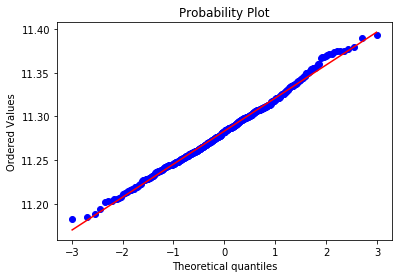

In [16]:
print('R-squared for control_boot_means: %.3f' % scipy.stats.probplot(control_boot_means, plot=plt, fit=True)[1][2])

q-q plot for control_boot_chi_squared

R-squared for control_boot_chi_squared: 0.998


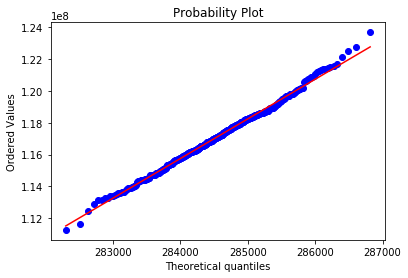

In [17]:
n = boot_samples.shape[1]
print('R-squared for control_boot_chi_squared: %.3f' % scipy.stats.probplot(control_boot_chi_squared, 
                                                                            dist="chi2", sparams=(n-1), 
                                                                            plot=plt, fit=True)[1][2])

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [18]:
exp.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
4,7,Browser #4,exp,54,68,30
6,9,Browser #4,exp,6,3,1


In [19]:
exp_users_clicks = pd.pivot_table(exp, index=['userID'], values=['n_clicks'], aggfunc=np.sum)
control_users_clicks = pd.pivot_table(control, index=['userID'], values=['n_clicks'], aggfunc=np.sum)

In [54]:
scipy.stats.mannwhitneyu(exp_users_clicks, control_users_clicks, alternative='two-sided')

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [55]:
data = []
nonclk_queries_ratio = []

browsers = pd.unique(ab_test['browser'])

for browser in browsers:
    
    browser_data = ab_test[ab_test['browser'] == browser]
    browser_exp = browser_data[browser_data['slot'] == 'exp']
    browser_control = browser_data[browser_data['slot'] == 'control']
        
    stat, p = scipy.stats.mannwhitneyu(browser_exp['n_clicks'], browser_control['n_clicks'], alternative='two-sided')
    
    exp_ratio = (browser_exp['n_nonclk_queries'].sum() / browser_exp['n_queries'].sum()) * 100
    control_ratio = (browser_control['n_nonclk_queries'].sum() / browser_control['n_queries'].sum()) * 100
    
    data.append([browser, p])
    nonclk_queries_ratio.append([browser, exp_ratio, control_ratio])

In [61]:
browser_tests = pd.DataFrame.from_records(data)
browser_tests.columns = ['browser', 'p']
browser_tests['reject'] = browser_tests['p'] < .05
browser_tests


,browser,p,reject
0,Browser #2,0.054488,False
1,Browser #4,0.815212,False
2,Browser #14,0.000000,True
3,Browser #17,0.074801,False
4,Browser #20,0.907333,False
5,Browser #22,0.514811,False


In [57]:
reject_corrected, p_corrected, a1, a2 = multipletests(browser_tests.p, 
                                            alpha = .05, 
                                            method = 'holm') 

In [62]:
browser_tests['p_corrected'] = p_corrected
browser_tests['reject_corrected'] = reject_corrected
browser_tests

,browser,p,reject,p_corrected,reject_corrected
0,Browser #2,0.054488,False,0.272439,False
1,Browser #4,0.815212,False,1.000000,False
2,Browser #14,0.000000,True,0.000000,True
3,Browser #17,0.074801,False,0.299205,False
4,Browser #20,0.907333,False,1.000000,False
5,Browser #22,0.514811,False,1.000000,False


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

In [49]:
nonclk_ratio = pd.DataFrame.from_records(nonclk_queries_ratio)
nonclk_ratio.columns = ['browser', 'exp_ratio', 'control_ratio']
nonclk_ratio['less'] = nonclk_ratio['exp_ratio'] < nonclk_ratio['control_ratio']

In [63]:
nonclk_ratio

,browser,exp_ratio,control_ratio,less
0,Browser #2,44.982747,45.962747,True
1,Browser #4,45.142942,46.970930,True
2,Browser #14,43.755617,57.590411,True
3,Browser #17,36.937413,36.299367,False
4,Browser #20,38.977376,40.540485,True
5,Browser #22,39.853947,40.593977,True
